In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from scipy.io import loadmat
from pandas import DataFrame
import scipy.signal as spsig
from sklearn import preprocessing
import pandas as pd
import csv
from tqdm import tqdm
from scipy.stats import zscore, iqr
import eeglib
import tsfeatures as tf
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

## Preproccess data

### Train

In [2]:
def proccess_train_data(pat):
    read_dir = '/Volumes/Udai_Mac_2022/Data_storage/Pat'+str(pat)+'Train' 
    filenames = sorted(os.listdir(read_dir))
    train_filenames = []
    for filename in filenames:
        train_filenames.append(filename)
    n = len(train_filenames)
    image = loadmat(read_dir + '/' + train_filenames[0], squeeze_me=True)
    X = np.zeros(((n,) + image['data'].shape), dtype='float32')
    y = np.zeros(n, dtype='int8')

    filename_to_idx = {}
    for i, filename in enumerate(train_filenames):
        try:
            data= loadmat(read_dir + '/' + filename, squeeze_me=True)
        except:
            continue
        X[i] = zscore(data['data'])
        y[i] = 1 if filename.endswith('_1.mat') else 0
        filename_to_idx['Pat'+str(pat) + '/' + filename] = i
    
    return X, y

In [3]:
#X_1, y_1 = proccess_train_data(1)
X, y = proccess_train_data(1)
print(X.shape)
print(y.shape)
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

(824, 240000, 16)
(824,)


{0: 569, 1: 255}

### Test

In [4]:
def proccess_test_data(pat):
    test_csv = pd.read_csv('data/contest_test_data_labels_public.csv')
    test_csv = test_csv[test_csv['usage'] == 'Public']
    test_csv = test_csv.drop(['usage'], axis = 1)
    test_labels = test_csv['class']

    pats = [1,2,3]
    for p in pats:
        if p != pat:
            test_csv = test_csv[test_csv["image"].str.contains('Pat'+str(p)) == False]

            
    test_n = test_csv.shape[0]
    read_dir = '/Volumes/Udai_Mac_2022/Data_storage/Pat'+str(pat)+'Test' 
    x_test = np.zeros(((test_n,) + (240000, 16)), dtype='float32')
    y_test = np.zeros(test_n, dtype='int8')
    filename_to_idx_test = {}
    idx = 0
    for index, row in test_csv.iterrows():
        datum = loadmat(read_dir + '/' + row['image'], squeeze_me=True)
        x_test[idx] = datum['data']
        y_test[idx] = row['class']
        filename_to_idx_test['Pat'+ str(pat) + '/' + row['image']] = index
        idx += 1
    
    return x_test, y_test

In [5]:
#test_X_1, test_y_1 = proccess_test_data(1)
test_X, test_y = proccess_test_data(1)
print(test_X.shape)
print(test_y.shape)
unique, counts = np.unique(test_y, return_counts=True)
dict(zip(unique, counts))

(61, 240000, 16)
(61,)


{0: 45, 1: 16}

## Feature Extraction

### Feature graphs

In [7]:
bands={'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'low-gamma': (30,47), 'hig-gamma':(53,120)}

eeg_data = eeglib.eeg.EEG(240000, 400, 16)
eeg_data.set(X[0])
b_pwr = eeg_data.bandPower(bands=bands)
data_full = np.zeros((16,6), dtype='float32')
idx = 0
for i in b_pwr:
    data_full[idx] = list(i.values())
    idx += 1

data_full = data_full.astype(float)
data = preprocessing.scale(data_full, axis=1,with_std=True)

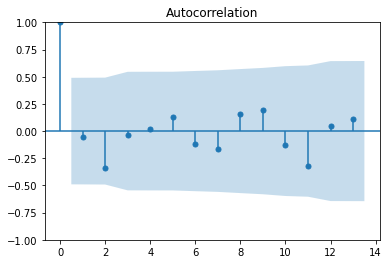

In [9]:
sm.graphics.tsa.plot_acf(data.T[0], lags=13)
plt.show()

In [704]:
for i in data.T:
    tsf_acf = tf.acf_features(i)
    model = AutoReg(i, lags=7)
    model_fit = model.fit(cov_type="HC0")
    coef = model_fit.params
    

print(coef)
print(tsf_acf)
LRresult = (model_fit.summary().tables[1])
sum = pd.DataFrame(LRresult)
print(sum) # coef = [1][2] error [2][2]

[-1.17912996  0.1348176  -0.35326257 -1.30785359 -0.11783012  2.12992504
  0.55420512 -3.1194965 ]
{'x_acf1': 0.39606803503504345, 'x_acf10': 0.48782665230560424, 'diff1_acf1': -0.2963474684036706, 'diff1_acf10': 0.13502337290733743, 'diff2_acf1': -0.5823523991345141, 'diff2_acf10': 0.38911081601561276}
       0           1          2          3       4          5          6
0               coef    std err          z   P>|z|     [0.025     0.975]
1  const     -1.1791      1.591     -0.741   0.459     -4.297      1.939
2   y.L1      0.1348      0.506      0.266   0.790     -0.857      1.127
3   y.L2     -0.3533      0.244     -1.446   0.148     -0.832      0.126
4   y.L3     -1.3079      1.490     -0.878   0.380     -4.227      1.612
5   y.L4     -0.1178      0.998     -0.118   0.906     -2.074      1.838
6   y.L5      2.1299      1.449      1.470   0.142     -0.710      4.970
7   y.L6      0.5542      0.542      1.023   0.306     -0.508      1.616
8   y.L7     -3.1195      3.012     -1

### Extraction Method

In [3]:
def feature_extraction_csv(pat,type,X,y):
    outfile = 'pat_'+str(pat)+'_feature_bands_'+type+'.csv'
    mydata = []

    # band (0.1 - 4 ; 4- 8 ; 8 - 15 ; 15 - 30 ; 30 - 90 ; 90 - 170 Hz
    bands={'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'low-gamma': (30,47), 'hig-gamma':(53,120)}
    for idx, x in tqdm(enumerate(X)):
        data_raw = x.T
        data_raw = data_raw.astype(float)
        data_raw = preprocessing.scale(data_raw, axis=1,with_std=True)


        eeg_data = eeglib.eeg.EEG(240000, 400, 16)
        eeg_data.set(x)
        b_pwr = eeg_data.bandPower(bands=bands)
        data_full = np.zeros((16,6), dtype='float32')
        ind = 0
        for i in b_pwr:
            data_full[ind] = list(i.values())
            ind += 1

        output = []
        featureList = []
        featureList.append('Label')
        output.append(y[idx])
        featureList.append('Pat')
        output.append(pat)
        data_full = data_full.astype(float)
        data_band = preprocessing.scale(data_full, axis=1,with_std=True)
        data_band = np.nan_to_num(data_band)

        # for band, i in enumerate(data_raw):
        #     featureList.append('M_RAW_%i'%(band))
        #     output.append(np.average(i))

        ### FEATURE 1 - CORRELATION COEF (count - 1)
        h=np.corrcoef(data_raw)
        h=np.nan_to_num(h)
        ind = np.triu_indices(16, 1)
        htri = h[ind]
        featureList.append('coef_1_')  #('coef_%i'%(ii))
        output.append(np.max(htri))
        featureList.append('coef_2_')  #('coef_%i'%(ii))
        output.append(np.partition(htri.flatten(), -2)[-2])
        
        ### FEATURE 2 - CORRELATION COEF BANDS (count - 1)
        h=np.corrcoef(data_band)
        h=np.nan_to_num(h)
        ind = np.triu_indices(16, 1)
        htri = h[ind]
        featureList.append('coef_band_')  
        output.append(np.max(htri))
        featureList.append('coef_band2_')  #('coef_%i'%(ii))
        output.append(np.partition(htri.flatten(), -2)[-2])
        
        ### FEATURE 3 - AR 1 and sum of 10 coef (count - 6 (1 per band))
        for band, i in enumerate(data_band.T):
            tsf_acf = tf.acf_features(i)
            featureList.append('AR_%i'%(band))
            output.append(tsf_acf['x_acf1'])
            featureList.append('AR_10_%i'%(band))
            output.append(tsf_acf['x_acf10'])
            # featureList.append('AR_D1_10_%i'%(band))
            # output.append(tsf_acf['diff1_acf10'])

       
        ### FEATURE 4 - MEAN BAND POWER 
        for band, i in enumerate(data_band.T):
            featureList.append('MEAN_%i'%(band))
            output.append(np.average(i))
        
        ### FEATURE 5 - STD BAND POWER 
        for band, i in enumerate(data_band.T):
            featureList.append('STD_%i'%(band))
            output.append(np.std(i))

        ### FEATURE 6 - IQR BAND POWER 
        for band, i in enumerate(data_band.T):
            featureList.append('IQR_%i'%(band))
            output.append(iqr(i, interpolation = 'midpoint'))

        ### FEATURE 7 - HJORTH
        h_comp = eeg_data.hjorthComplexity()
        featureList.append('HJORTH_COMP_MAX_')
        output.append(np.max(h_comp))
        featureList.append('HJORTH_COMP_AVG_')
        output.append(np.average(h_comp))

        h_mob = eeg_data.hjorthMobility()
        featureList.append('HJORTH_MOB_MAX_')
        output.append(np.max(h_mob))
        featureList.append('HJORTH_MOB_AVG_')
        output.append(np.average(h_mob))

        # h_act = eeg_data.hjorthActivity()
        # featureList.append('HJORTH_ACT_MAX_')
        # output.append(np.max(h_act))
        # featureList.append('HJORTH_ACT_AVG_')
        # output.append(np.average(h_act))


        ### FEATURE 8 - MEAN ABSOLUTE DEVIATION
        for band, i in enumerate(data_band.T):
            featureList.append('MAD_%i'%(band))
            output.append(np.mean(np.absolute(i - np.mean(i))))
        


        mydata.append(pd.DataFrame({'Features':output},index=featureList).T)

    trainSample = pd.concat(mydata,ignore_index=True)
    trainSample.to_csv(outfile)

In [128]:
feature_extraction_csv(1,'train', X, y)
feature_extraction_csv(1,'test', test_X, test_y)

824it [39:40,  2.89s/it]


### Feature cleaning

In [ ]:
pat = 1
features_train = pd.read_csv('pat_'+str(pat)+'_feature_bands_train.csv')
features_test = pd.read_csv('pat_'+str(pat)+'_feature_bands_test.csv')

In [7]:
print(features_train.shape)
print(features_test.shape)
print("Number of features:",features_test.shape[1]-3)

(2001, 39)
(297, 39)
Number of features: 36


In [46]:
features_train.dropna(thresh=features_train.shape[1]-3, inplace=True)
features_train.replace([np.inf, -np.inf], np.nan, inplace=True)
features_train.fillna(0, inplace=True)

features_test.dropna(thresh=features_test.shape[1]-3, inplace=True)
features_test.replace([np.inf, -np.inf], np.nan, inplace=True)
features_test.fillna(0, inplace=True)

In [47]:
label_train = features_train.Label.values
label_test = features_test.Label.values
x_train = features_train.drop(['Label', 'Pat', 'Unnamed: 0'], axis=1)
x_test= features_test.drop(['Label', 'Pat', 'Unnamed: 0'], axis=1)

## Model

In [21]:
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from xgboost import plot_importance
from sklearn.decomposition import PCA


In [151]:
pca = PCA(0.95)
principalComponents = pca.fit_transform(x_train)
principalComponents_test = pca.transform(x_test)
principalComponents_test.shape

(297, 5)

### XGB

In [79]:
params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "eta": 0.001,
        "max_depth": 6,
        "subsample": 1,
        "gamma": 0.1,
        "colsample_bynode": .1,
        "reg_lambda": .82,
    }

dtrain=xgb.DMatrix(x_train, label_train)
model=xgb.train(params,dtrain,num_boost_round=500,verbose_eval=20)

test=xgb.DMatrix(x_test)
y_pred = model.predict(test)
auc = metrics.roc_auc_score(label_test, y_pred)
print ("AUC: " + str(auc)) 


AUC: 0.7027777777777778


AUC: 0.7013888888888888

"objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "eta": 0.001,
        "max_depth": 6,
        "subsample": 1,
        "gamma": 0.1,
        "colsample_bynode": 0.1,
        "reg_lambda": 0.8200000000000001,
    }

<AxesSubplot:>

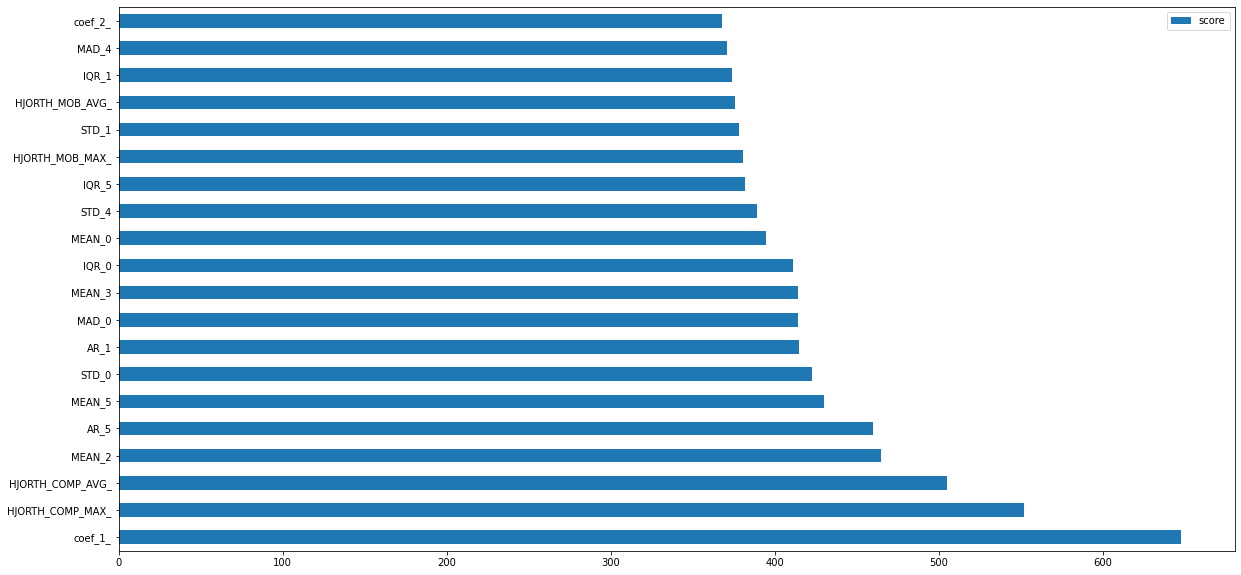

In [74]:
feature_important = model.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [107]:
mod = xgb.XGBRFClassifier(n_estimators=200, learning_rate=0.01, subsample=1, colsample_bynode=0, use_label_encoder=False)
mod.fit(x_train, label_train)
y_pred = mod.predict(x_test)

auc = metrics.roc_auc_score(label_test, y_pred)
print ("AUC: " + str(auc))

[21:01:47] WARNING: /private/var/folders/h6/y3hp258s05s0fmq2lhy3v1800000gn/T/pip-install-cdc2w_yl/xgboost/build/temp.macosx-10.9-x86_64-3.8/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.6368055555555556


### ExtraTree

In [108]:
clf = ExtraTreesClassifier(n_estimators=4000, max_features=25, random_state=0, max_depth=15, criterion='entropy')
clf.fit(x_train,label_train)
y_pred = clf.predict(x_test)

auc = metrics.roc_auc_score(label_test, y_pred)
print ("AUC: " + str(auc))

AUC: 0.6527777777777778


0.6840277777777778  
3000, 25, 11

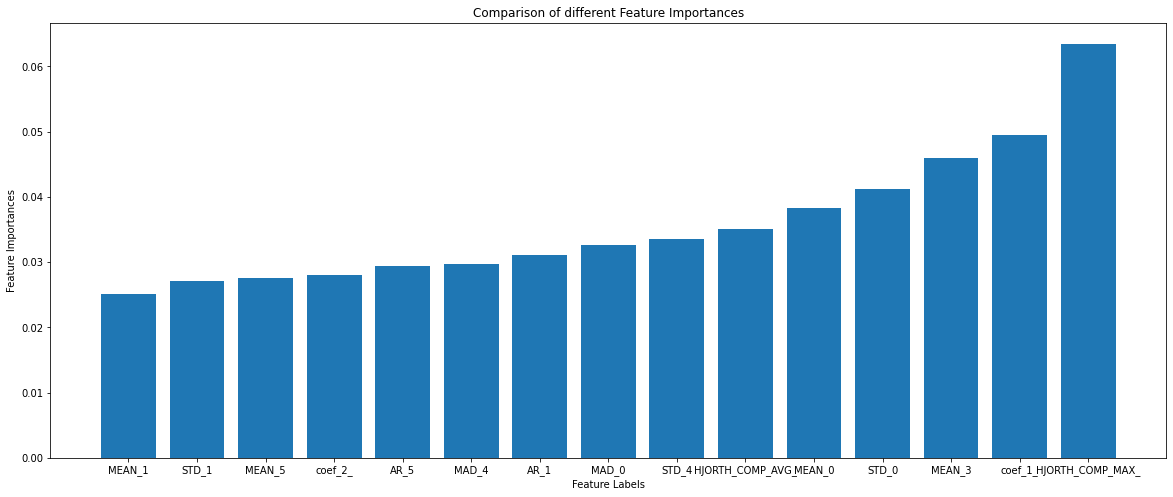

In [124]:
feature_importance = clf.feature_importances_
feature_importance_normalized = np.std([tree.feature_importances_ for tree in clf.estimators_], axis = 0)
sorted_idx = (clf.feature_importances_.argsort())

plt.bar(x_train.columns[sorted_idx[-15:]],clf.feature_importances_[sorted_idx[-15:]])
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.rcParams["figure.figsize"] = (20,8)
plt.show()

### KNN

In [132]:
knn = KNeighborsClassifier(n_neighbors=21, metric='manhattan', weights='uniform', n_jobs=-1)
knn.fit(x_train,label_train)
y_pred = knn.predict(x_test)

auc = metrics.roc_auc_score(label_test, y_pred)
print ("AUC: " + str(auc))


AUC: 0.5224014336917563


0.6895833333333333

## Results


| Feature | Feature count (per sample) | Final Model |
| --- | --- | --- |
| Coorelation Coefficient (raw data) | 2 (highest 2) | X |
| Coorelation Coefficient (band power) | 2 (highest 2 | X |
| AutoCorrelation First Coefficient | 6 (1 per band) | X |
| AutoCorrelation Sum of 10 Coefficient | 6 (1 per band) | X |
| AutoCorrelation Sum of 10 squared Coefficient | 6 (1 per band) | -- |
| Mean band power | 6 (1 per band) | X |
| IQR band power | 6 (1 per band) | X |
| Standard Deviation band power | 6 (1 per band) | X |
| Mean Absolute Deviation band power | 6 (1 per band) | X |
| Hjorth Complexity (max and mean) | 2 | X |
| Hjorth Mobility (max and mean) | 2 | X |
| Hjorth Activation (max and mean) | 2 | -- |